In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')
# pd.set_option('display.max_rows', None)

In [2]:
import os
path = "../"
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [4]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [5]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [6]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수

In [7]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [8]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율',
       '세대당_가능주차면수', '공가수비율', '대형전용면적'],
      dtype='object')

In [11]:
# train.to_csv("train_f.csv")
# test.to_csv("test_f.csv")

In [10]:
#train["법정동_세대수"]=(train.총인구수/train.세대당_인구)/train.총세대수
#test["법정동_세대수"]=(test.총인구수/test.세대당_인구)/test.총세대수

#train["임대비율"]=train.임대보증금/train.임대료
#test["임대비율"]=test.임대보증금/test.임대료

#train["잉여주차"]=train.단지내주차면수-train.총세대수
#test["잉여주차"]=test.단지내주차면수-test.총세대수

In [9]:
#train.subway_dist=1/train.subway_dist
#test.subway_dist=1/test.subway_dist
#train.loc[(train.subway_dist<0.529094), "subway_dist"]=0
#test.loc[(test.subway_dist<0.529094), "subway_dist"]=0

# 자격유형

In [12]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [13]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [14]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [15]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [16]:
train.shape, test.shape

((2577, 38), (936, 37))

# 1차원

In [17]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '자격유형_카테고리'],
      dtype='object')

In [18]:
len(set(train.단지코드))

414

In [19]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [20]:
data.shape

(414, 30)

In [21]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구임대,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [22]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [23]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [24]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,877964.187248,1.038396e+07
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [25]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [26]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [27]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [28]:
data=data.fillna(0)

In [29]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [30]:
data=pd.merge(data, sample, on="단지코드", how="inner")

# Test에 똑같이

In [31]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 29)

In [32]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [33]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [34]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수'] #전용면적별세대수
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [35]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,1.158750e+05,2.265000e+07
1,C1006,2.333169e+06,1.754953e+07
2,C1016,2.280100e+05,2.402675e+07
3,C1019,1.264300e+05,1.485750e+07
4,C1030,2.142167e+05,5.141333e+07


In [36]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [37]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [38]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [39]:
dat=dat.fillna(0)

In [40]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [41]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [42]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',  '행복주택',        '영구임대',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',            '자격유형2',            '자격유형7',
                  '자격유형1',             '자격유형6',             '자격유형3',            '자격유형5',
             '대형전용면적']

In [43]:
data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율', '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',        '장기전세',        '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금',             '자격유형1',             '자격유형2',            '자격유형7',
                   '자격유형3',           '자격유형6',             '자격유형4',            '자격유형5',
            '대형전용면적']

# 987보다 큰 지역에 area 카테고리 추가
밑에서 반영

# 전용면적

In [50]:
#sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].mean()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["전용면적"].std()).reset_index()
#sample3=pd.DataFrame(train.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#data.head()

In [43]:
#sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].mean()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["전용면적"].std()).reset_index()
#sample3=pd.DataFrame(test.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")
#dat=pd.merge(dat, sample3, on="단지코드", how="inner")
#dat.head()

In [44]:
#sample1=pd.DataFrame(train.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["임대보증금"].std()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#sample1=pd.DataFrame(test.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["임대보증금"].std()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")

# Correlation 확인

In [45]:
#X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역"])

In [46]:
#X_cor = pd.get_dummies(X_cor, drop_first=True)

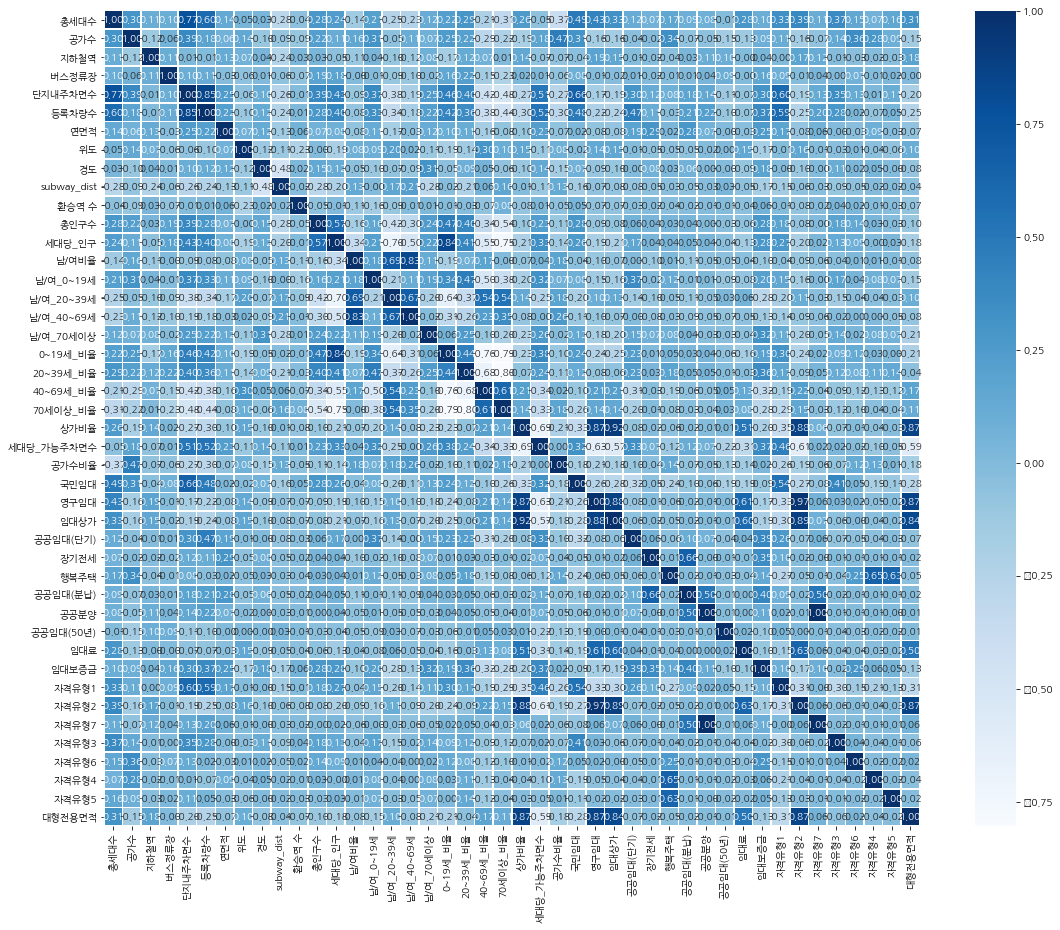

In [47]:
#plt.subplots(figsize=(20,15))
#sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [52]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from statsmodels.api import OLS

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()
#standardScaler.fit(X_train)
#X_train = standardScaler.transform(X_train)
#standardScaler.fit(X_test)
#X_test = standardScaler.transform(X_test)

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [49]:
#pd.concat([pd.DataFrame(data.단지내주차면수.describe()),
#           pd.DataFrame(dat.단지내주차면수.describe())], axis=1)

,단지내주차면수,단지내주차면수
count,414.000000,147.000000
mean,586.330918,558.387755
std,363.665625,321.009953
min,13.000000,29.000000
25%,318.250000,313.000000
50%,517.000000,499.000000
75%,785.750000,726.000000
max,1798.000000,1696.000000


In [53]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [53]:
#train1=data[data.단지내주차면수<987]
#train2=data[data.단지내주차면수>=987]
#test1=dat[dat.단지내주차면수<987]
#test2=dat[dat.단지내주차면수>=987]
#print(train1.shape, train2.shape)
#print(test1.shape, test2.shape)

## 나눠서 modeling

In [54]:
# def fit(X_train, X_test, y_train, y_test, model):
#     try:
#         model.fit(X_train, y_train, verbose=False)
#     except:
#         model.fit(X_train, y_train)
#     tst_pred = model.predict(X_test)
#     error = mean_absolute_error(y_test,tst_pred)
#     return model, tst_pred, error


# def fit_models(X, y, models, cv=False):
#     X = np.array(X.reset_index(drop=True))
#     y = np.array(y.reset_index(drop=True))
#     best_error = 10000
#     best_tst_pred = 0
#     best_model = ""
#     if cv==False:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
#         for m in models:
#             model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
#             if best_error > error:
#                 best_error = error
#                 best_tst_pred = tst_pred
#                 best_model = model
#     else:
#         best_tst_idx = []
#         kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
#         for m in models:
#             mae = []
#             pred= []
#             tst_idx = []
#             for train_index, test_index in kf.split(X, y):
#                 X_train, X_test = X[train_index], X[test_index]
#                 y_train, y_test = y[train_index], y[test_index]
#                 model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
#                 mae.append(error)
#                 pred.append(tst_pred.tolist())
#                 tst_idx.append(test_index.tolist())
#             cv_error = np.mean(mae)
#             print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
#             if best_error > cv_error:
#                 best_error = cv_error
#                 best_tst_pred = pred
#                 best_tst_idx = sum(tst_idx, [])
#                 best_model = model
#         best_tst_pred = sum(best_tst_pred,[])
#         best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
#     try:
#         best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
#                                                 np.concatenate((y_train, y_test),axis=0), 
#                                                 verbose=False)
#     except:
#         best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
#                                         np.concatenate((y_train, y_test),axis=0))
#     return best_model, best_tst_pred, best_error

In [55]:
#models = [LinearRegression(), 
#          PLSRegression(), 
#          Ridge(random_state=2021),
##          Lasso(random_state=2021), 
#          ElasticNet(random_state=2021),
#          #SVR(),
#          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
#          RandomForestRegressor(criterion="mae",random_state=2021),
#          GradientBoostingRegressor(criterion="mae",random_state=2021),
#          XGBRegressor(random_state=2021)]

In [56]:
#X1 = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
#                         '등록차량수', "임대상가",
#                         "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])
#X1 = pd.get_dummies(X1, drop_first=True)
#y1=train1["등록차량수"]
#best_model1, best_tst_pred1, best_error1 = fit_models(X1, y1, models, cv=True)

In [57]:
#X2=train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
#                         '등록차량수', "임대상가","자격유형2", 
#                        "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])
#X2 = pd.get_dummies(X2, drop_first=True)
#y2=train2["등록차량수"]
#best_model2, best_tst_pred2, best_error2=fit_models(X2, y2, models, cv=True)

In [58]:
#기존=pd.merge(pd.DataFrame(best_tst_pred1,index=[0]).T.reset_index(),
#         pd.DataFrame(train1.단지코드.reset_index(drop=True)).reset_index(),
#         on="index")
#
#자격유형드랍=pd.merge(pd.DataFrame(best_tst_pred_1,index=[0]).T.reset_index(),
#         pd.DataFrame(train1.단지코드.reset_index(drop=True)).reset_index(),
#         on="index")
#
#df=pd.merge(기존, 자격유형드랍, on="단지코드", how='inner')
#df=df.drop(columns=["index_x", "index_y"])
#df=pd.merge(df, train1[["단지코드", "등록차량수"]], on="단지코드", how="inner")
#df.columns=['pred_기본', '단지코드', 'pred_자격유형x', 'real_Y']
#df=df[['단지코드', 'pred_기본', 'pred_자격유형x', 'real_Y']]
#df["diff"]=abs(df.pred_기본-df.pred_자격유형x)
#df.sort_values("diff")

# 나눠서 예측

In [63]:
sample=pd.read_csv('../EDA/data/sample_submission.csv')
sample.head()

,code,num
0,C1072,676.17
1,C1128,1203.84
2,C1456,547.00
3,C1840,771.06
4,C1332,1100.88


In [64]:
sample.shape

(150, 2)

In [75]:
train1=data[data.단지내주차면수<987]
train2=data[data.단지내주차면수>=987]
test1=dat[dat.단지내주차면수<987]
test2=dat[dat.단지내주차면수>=987]

In [76]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(362, 49) (52, 49)
(128, 46) (19, 46)


In [77]:
df= pd.concat([train1, test1])

In [78]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)

In [79]:
X_train1=X.iloc[0:362, :]
X_test1=X.iloc[362:, :]
y_train1 = train1[['등록차량수']]

X_test1["장기전세"]=0
X_test1["공공분양"]=0

In [105]:
model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train1, y_train1)
model1_pred = model_1.predict(X_test1)
model1_pred[:10]

array([751.54095109, 539.40911632, 533.22023432, 464.13479698,
       364.18748705, 309.46683792, 482.48834784, 224.868781  ,
       416.06605359, 249.03570578])

In [57]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [58]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1.head()

,code,num
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487


In [59]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [60]:
train2['지역'] = train2['지역'].apply(lambda x : areafunc(x))
test2['지역'] = test2['지역'].apply(lambda x : areafunc(x))
train2 = train2.join(pd.get_dummies(train2['지역'],prefix='area')).iloc[:,:-1]
test2 = test2.join(pd.get_dummies(test2['지역'],prefix='area')).iloc[:,:-1]

In [98]:
X_train2 = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7","지역"]) 
y_train2 = train2['등록차량수']
X_test2 = test2.drop(columns=['단지명','단지코드','도로명주소','subway_name','임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7","지역"]) 
X_test2['공공분양']=0
X_test2['장기전세']=0

In [102]:
X_test2.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '행복주택', '영구임대',
       '국민임대', '공공임대(50년)', '공공임대(단기)', '공공임대(분납)', '임대료', '임대보증금', '대형전용면적',
       '공공분양', '장기전세'],
      dtype='object')

In [62]:
model_2= CatBoostRegressor(random_state=2021, loss_function = 'MAE', verbose=False).fit(X_train2, y_train2) 
model2_pred = model_2.predict(X_test2)

In [63]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [64]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2.head()

,code,num
0,C1128,1188.382634
1,C1332,1327.919226
2,C1563,1797.687836
3,C1794,1048.372040
4,C1152,847.316183


In [65]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [66]:
df_merge

,code,num
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487
...,...,...
142,C1525,1139.379376
143,C2267,940.641339
144,C1692,969.004960
145,C1570,899.031182


In [80]:
df_merge.head()

,code,num
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487


In [81]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [97]:
test_split.head()

,code,num
0,C1072,751.540951
1,C1128,1188.382634
2,C1456,539.409116
3,C1840,533.220234
4,C1332,1327.919226


In [83]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [84]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [98]:
one=pd.read_csv("put_area.csv")
one = pd.merge(sample, one, on="code")
one= one.drop(columns='num_x')
one.columns=["code","num"]
one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]

test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]

mean_absolute_error(one.num, test_.num)

2.977512416518515e-14

Text(0.5, 0, 'CatBoost1 Feature Importance')

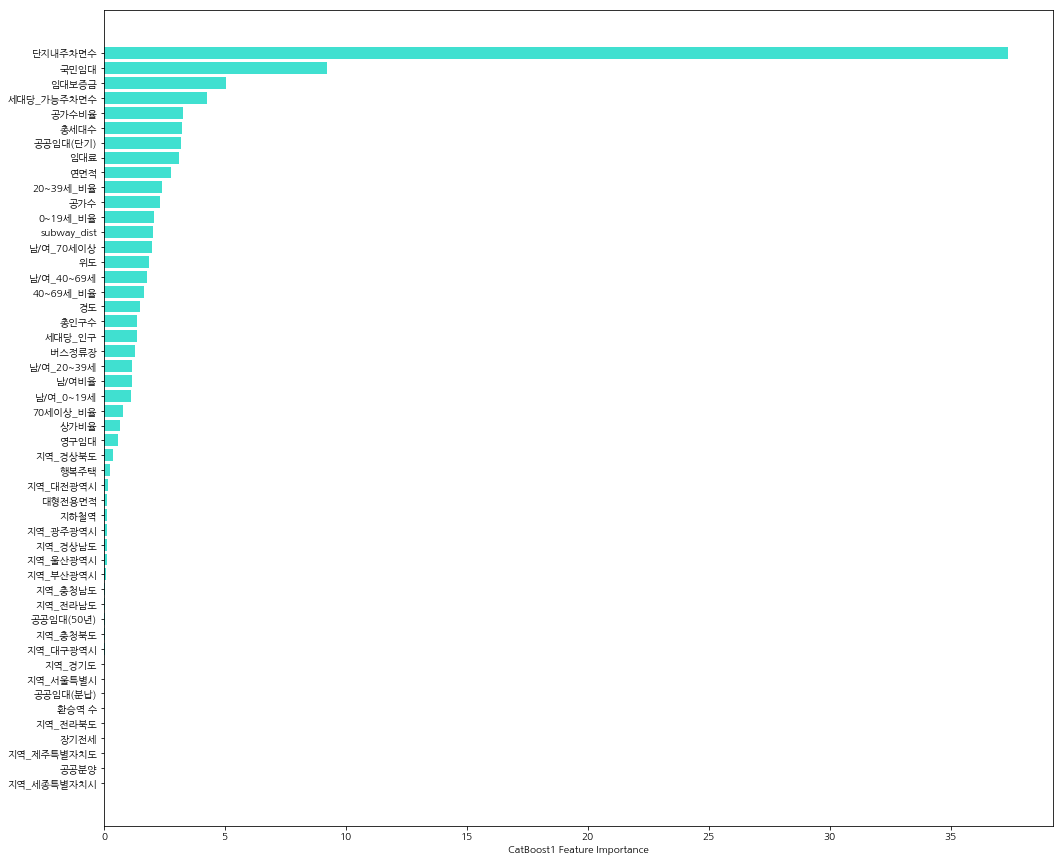

In [82]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X_train1.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost1 Feature Importance")

Text(0.5, 0, 'CatBoost2 Feature Importance')

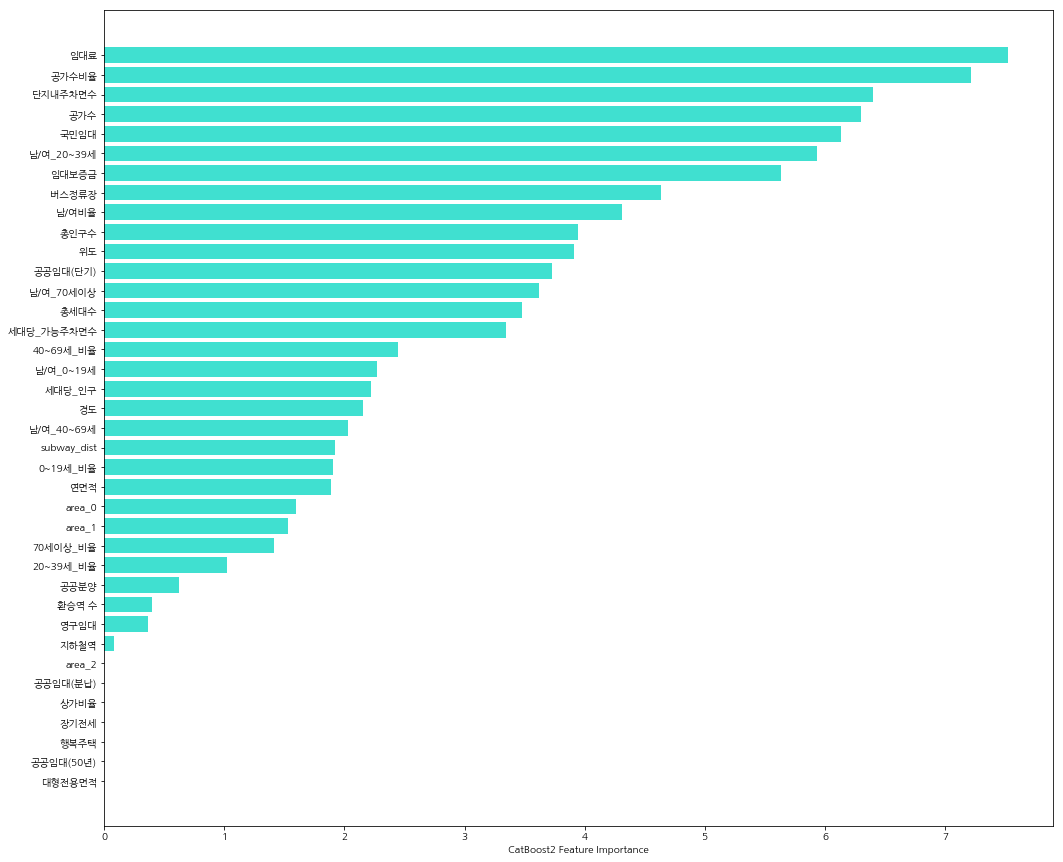

In [81]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_2.feature_importances_.argsort()
plt.barh(X_train2.columns[sorted_feature_importance], 
        model_2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost2 Feature Importance")

In [76]:
# test_split.to_csv(' .csv', index=False)